#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
# Reading source data.
training_data = pd.read_csv('training.csv')

In [3]:
#Images are stored as string. We convert them to a np array. 

images = training_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))
images = np.vstack([images.iloc[i] for i in range(len(images))])

In [4]:
#Creating keypoints dataframe. 
keypoints = training_data.drop('Image', axis = 1)

## Data augmentation: Including reflected pictures into the dataset

In order to increase our dataset I will reflect all images left to right, and add them as different images.

This implies flipping the images, and reflecting all x-coordinates of the keypoints such that $x_{reflected} = 95 - x_{old}$.


In [5]:
# building an array of reflected images.
flipped_ims = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_ims[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [6]:
# adding the reflected images to our images array. 
# RUN THIS CELL ONLY ONCE. 
images = np.vstack((images, flipped_ims))

In [7]:
# Now the keypoints. I need to switch left and right features, 
# and reflect the x coordinates by x --> 95-x (95 is the last coordinate of the picture. )

reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# We look for the correspoding columns by switching 'left' <--> 'right'.
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    # reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    # the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

In [8]:
# Adding reflected keypoints to the original keypoints. 
# RUN THIS CELL ONLY ONCE.
keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

## Perform a train_test_split in order to have a cross validation set. 

In [41]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=100, random_state = 42)

In [11]:
# BASELINE
# As a guide, we compute the error on the cv set obtained by using the mean position of
# each keypoint.

mean_keypoints = keypoints_train.mean()
baseline_rmse = np.sqrt(((keypoints_cv - mean_keypoints)**2).mean().mean())

print('Using the mean poistion the RMSE on the cv set is: ', baseline_rmse)

Using the mean poistion the RMSE on the cv set is:  3.1721240528361268


A good estimation should improve on this result. 

##  Define a function for taking random batches. 

In [12]:
def next_batch(X, labels, batch_size):
    """ A function for generating training batches. 
    X = Collection of examples.
    labels = True labels. 
    batch_size = Number of elements to be randomly selected. """
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [13]:
# Wrappers of tensorflow methods. This functions will help make
# the construction of the network more straightforward. 

def init_weights(shape):
    init_random_dist = tf.initializers.random_normal(stddev=0.1)
    #init_random_dist = tf.initializers.he_normal()
    return tf.get_variable('weights', shape=shape ,initializer= init_random_dist)

def init_bias(shape):
    #init_bias_vals = tf.random_uniform(shape=shape)
    init_bias_vals = tf.initializers.random_uniform()
    return tf.get_variable('bias', shape = shape ,initializer= init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

def output_act_function(input_layer):
    factor = tf.constant(96, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(input_layer))

def sigmoid_layer(input_layer, size, max_val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    factor = tf.constant(max_val, dtype = tf.float32)
    return tf.multiply(factor, tf.nn.sigmoid(tf.matmul(input_layer, W) + b))
    

def new_bn_layer(input_x, training, decay = 0.999):
    """ Wrapper function for tf.contrib.layers.batch_norm """
    
    return tf.contrib.layers.batch_norm(input_x, decay = decay, is_training = training  )

# Building the network

In [14]:
tf.reset_default_graph()

In [15]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)
#training = tf.placeholder(tf.bool)
drop_rate = tf.placeholder(tf.float32)

In [16]:
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [17]:
# LAYERS

with tf.variable_scope('Convo1'):
    convo1 = convolutional_layer(x_images, [6,6,1,32]) # 6 x 6 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

    convo1_pool = tf.nn.max_pool(convo1, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')   #output of 24 x 24 x 32
        
with tf.variable_scope('Convo2'):    
    convo2 = convolutional_layer(convo1_pool, [2,2,32,64]) # 4x4 filter, 64 outputs. SAME padding.

    convo2_pool = max_pool_2by2(convo2) # 12 x 12 x64
    
            
with tf.variable_scope('Convo3'):
    convo3 = convolutional_layer(convo2_pool, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

    convo3_pool = max_pool_2by2(convo3) # 6 x 6 x 128

    convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])
    
with tf.variable_scope('Full_one'):
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))
    
        
# DROPOUT 

full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

# OUTPUT LAYER
with tf.variable_scope('Output'):
    
    keypoints_pred = normal_full_layer(full_one_dropout,30)
    

In [18]:
# LOSS FUNCTION
with tf.variable_scope('Loss'):
    masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred - keypoints_true, tf.is_finite(keypoints_true) ) ) ) 
                                 

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    train = optimizer.minimize(masked_loss)

Instructions for updating:
Use tf.cast instead.


/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [19]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [22]:
counter = 6

## Training

Currently on step 5000
Train MSE:  1.1986518 

CV MSE: 3.2258418 

train_losses =  [0.9714443, 1.5159959, 1.5915838, 1.5120442, 0.89996207, 1.4855001, 1.0153017, 1.2310232, 1.1646864, 1.3185337, 1.0040632, 1.3314778, 1.5011725, 1.2571129, 18.631939, 1.5533038, 1.1441553, 0.9563428, 1.0995024, 2.2929108, 1.2342179, 1.5577449, 0.8731444, 1.0340497, 1.1069318, 0.78375643, 0.8479234, 1.0648619, 1.0461363, 1.1021979, 1.650753, 1.1884928, 0.9789259, 1.5710648, 1.1080738, 1.3668627, 1.4449444, 1.0293518, 0.74534124, 1.7228281, 1.0341253, 1.3175883, 1.0196617, 0.8082124, 1.1936606, 0.96021223, 1.1036655, 0.7228589, 0.92690426, 0.80505645, 1.1986518] 

cv_losses =  [3.6454058, 3.4443705, 3.5713472, 3.3784056, 3.249156, 3.5970705, 3.3819184, 3.6900415, 3.6128287, 3.2823422, 3.3551173, 3.6695938, 3.4702837, 3.4912841, 3.9756572, 3.8575408, 3.230879, 3.3195338, 3.307307, 4.6383333, 3.1235104, 3.4265172, 3.2686057, 3.2422843, 3.4075708, 3.4409034, 3.2590427, 3.4856772, 3.4779932, 3.4963064, 3.51847

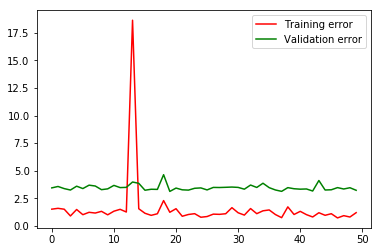

In [43]:
num_steps = 5000

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
    
    
    writer = tf.summary.FileWriter('./tensorboard_logs', sess.graph)
    #sess.run(init)
    saver.restore(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_3")
    train_losses = []
    cv_losses = []
    
    
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train,32)
        
        
        # Uncomment for BN
        _ , train_loss= sess.run([train, masked_loss], 
                             feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                        lr:0.0005, drop_rate:0})
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,
                               feed_dict={x:x_cv, keypoints_true:keypoints_cv, drop_rate:0})
            
            #I plot MSE because it is a bit easier to visualize. Small changes are larger. 
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            #train_losses.append(np.sqrt(train_loss))
            #cv_losses.append(np.sqrt(cv_loss))
                        
            # Showing output for tracking progress.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss)
            print('Train RMSE: ', np.sqrt(train_loss), '\n')
            print('CV MSE:', cv_loss)
            print('CV RMSE:', np.sqrt(cv_loss), '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            #print('train_losses = ', train_losses, '\n')
            #print('cv_losses = ', cv_losses)
            
            clear_output(wait = True)
    
    # printing final results
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_losses[-1], '\n')
    print('CV MSE:',  cv_losses[-1], '\n')

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    
            
    print('=======================================')
    print('train_losses = ', train_losses, '\n')
    print('cv_losses = ', cv_losses)
            
    saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    writer.close()
    #saver.save(sess, "./saved_models/keypoints_cnn_1"  )
    #counter +=1
    #print(counter)

In [44]:
cv_loss

3.2258418

In [48]:
np.mean(np.sqrt(train_losses)[-5:])

0.97112066

In [52]:
train_losses_mod6_15k.append(train_losses)

In [53]:
cv_losses_mod6_15k.append(cv_losses)

In [54]:
train_losses_mod6_20k = train_losses_mod6_15k

cv_losses_mod6_20k =  cv_losses_mod6_15k

print('train_losses = ', train_losses_mod6_20k)
print('cv_losses = ', cv_losses_mod6_20k)

train_losses =  [2746.89, 19.651209, 13.900487, 23.887327, 14.027125, 7.780022, 10.446969, 7.102882, 9.6294565, 10.828769, 6.2227793, 6.690764, 6.933126, 8.742841, 13.347056, 11.54475, 6.95353, 8.77213, 5.716919, 7.3303876, 6.1963983, 6.662679, 7.575607, 4.7556376, 6.5769863, 8.739519, 6.3515863, 6.999341, 8.082346, 8.221824, 4.525495, 3.9617662, 5.1980925, 5.6988044, 4.641099, 5.4294457, 5.6107492, 4.252821, 32.223003, 4.369542, 4.2668967, 3.6859336, 18.945686, 5.4189525, 3.9733317, 3.3470862, 4.8501625, 6.7137585, 4.303429, 4.4860005, 4.53415, 7.414834, 3.7151647, 3.3470926, 3.4155953, 2.5136485, 4.232387, 3.5191119, 2.7974353, 3.4864886, 4.1178837, 3.1648767, 3.1784732, 3.2590225, 4.8791018, 3.8478749, 3.0882132, 2.9822042, 3.9544997, 3.0890508, 3.0692906, 2.5876765, 3.6651385, 4.1632195, 2.7077122, 3.4702852, 3.6109354, 3.0374005, 3.9178162, 2.9304972, 3.0325334, 4.0522537, 2.5465722, 3.6056242, 3.5048845, 2.9059258, 2.4696338, 10.423276, 2.8496094, 2.071369, 3.479752, 2.3314476, 2

In [20]:
train_losses[np.argmax(train_losses)] = train_losses[np.argmax(train_losses)-1]

Text(0.5, 1.0, 'MSE')

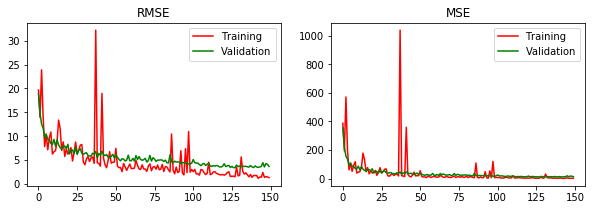

In [30]:
figure, ax = plt.subplots(1,2, figsize = (10,3))

ax[0].plot(train_losses[1:], 'r', label = 'Training')
ax[0].plot(cv_losses[1:], 'g', label = 'Validation')
ax[0].legend()
ax[0].set_title('RMSE')

ax[1].plot(list(map(lambda x: x**2, train_losses[1:])), 'r', label = 'Training')
ax[1].plot(list(map(lambda x: x**2, cv_losses[1:])), 'g', label = 'Validation')
ax[1].legend()
ax[1].set_title('MSE')




In [34]:
A = [1,2]
B = list(map(lambda x: x**2, A))
np.sqrt(B)

array([1., 2.])

## Predictions for the cv set

In [37]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_" + str(counter))

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions, loss = sess.run([keypoints_pred, masked_loss], feed_dict= {x:x_cv, keypoints_true:keypoints_cv, 
                                                                          drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_cnn_6


In [39]:
np.sqrt(loss)

1.4534221

In [ ]:
predictions.shape

In [ ]:
np.max(predictions)

In [ ]:
np.unravel_index( np.argmax(predictions), predictions.shape)

In [ ]:
predictions[73,29]

In [ ]:
x_cv.shape

In [ ]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'b*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

## Predictions for the test set

In [ ]:
test_data = pd.read_csv('test.csv')
test_data.shape

In [ ]:
test_data.head()

In [ ]:
test_images = test_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

test_images = np.vstack([test_images.iloc[i] for i in range(len(test_images))])

In [ ]:
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
    
    
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_" + str(counter))
    #saver.restore(sess, "./saved_models/keypoints_3_lay_cnn_3" )

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:test_images, drop_rate:0 })
    

In [ ]:
predictions.shape

In [ ]:
grid_size = 2
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

#selection = np.random.choice(range(len(test_images)), size = grid_size**2 )
selection = [131, 159, 491, 525]
for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(test_images[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    

## Make a dataframe with predictions

In [ ]:
predicted_keypoints = pd.DataFrame(data = predictions, columns = keypoints.columns)

In [ ]:
predicted_keypoints[(predicted_keypoints>96).any(1)]

In [ ]:
predicted_keypoints.to_csv('full_test_predictions_002.csv')

## Loading the lookup table to make a submission file. 

In [ ]:
lookup_table = pd.read_csv('IdLookupTable.csv', header = 0, index_col = 'RowId')

In [ ]:
locations_list = []
for i in lookup_table.iterrows():
    position = predicted_keypoints.iloc[i[1]['ImageId']-1][i[1]['FeatureName']]
    locations_list.append(position)
len(locations_list)

In [ ]:
#empty dataframe for testing submission
Submission_df = pd.DataFrame(columns = ['Location'], index = lookup_table.index)

In [ ]:
Submission_df['Location'] = locations_list

In [ ]:
Submission_df.to_csv('submission_002.csv')